In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
df_web = pd.read_csv('web.csv')
df_liaison = pd.read_csv('liaison.csv')
df_erp = pd.read_csv('erp.csv')

# MERGE + CLEANING DES DATAFRAME

In [3]:
df_web_cleaning = df_web.drop_duplicates(subset=['sku'])
df_web_cleaning = df_web_cleaning.dropna(axis=0, how='all')

In [4]:
df_1 = df_erp.merge(df_liaison, left_on='product_id', right_on='product_id')
df_all = df_1.merge(df_web_cleaning, left_on='id_web', right_on='sku')
df_all = df_all.drop(0) #Suppresion du "bon-cadeau-25-euros"
df_all.head(5)

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,sku,virtual,downloadable,rating_count,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
1,3849,1,34.3,0,outofstock,15296,15296,0,0,0,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
2,3850,1,20.8,0,outofstock,15300,15300,0,0,0,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
3,4032,1,14.1,0,outofstock,19814,19814,0,0,0,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
4,4039,1,46.0,0,outofstock,19815,19815,0,0,0,...,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
5,4040,1,34.3,0,outofstock,15303,15303,0,0,0,...,pierre-jean-villa-saint-joseph-saut-ange-2018,2019-11-02 13:25:07,2019-11-02 12:25:07,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0


In [5]:
#Repérer les colonnes 'inutiles'
df_all.describe()

,product_id,onsale_web,price,stock_quantity,virtual,downloadable,rating_count,average_rating,total_sales,tax_class,post_author,post_content,post_password,post_content_filtered,post_parent,menu_order,comment_count
count,804.000000,804.000000,804.000000,804.000000,804.0,804.0,804.0,713.0,713.000000,0.0,713.000000,0.0,0.0,0.0,713.0,713.0,713.0
mean,5158.976368,0.890547,32.676119,27.167910,0.0,0.0,0.0,0.0,4.009818,NaN,1.998597,NaN,NaN,NaN,0.0,0.0,0.0
std,905.728584,0.312401,27.050855,46.295229,0.0,0.0,0.0,0.0,8.523837,NaN,0.037450,NaN,NaN,NaN,0.0,0.0,0.0
min,3849.000000,0.000000,5.200000,0.000000,0.0,0.0,0.0,0.0,0.000000,NaN,1.000000,NaN,NaN,NaN,0.0,0.0,0.0
25%,4327.250000,1.000000,14.575000,1.000000,0.0,0.0,0.0,0.0,0.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
50%,4901.500000,1.000000,24.450000,12.000000,0.0,0.0,0.0,0.0,1.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
75%,5804.250000,1.000000,42.525000,34.250000,0.0,0.0,0.0,0.0,4.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
max,7338.000000,1.000000,225.000000,578.000000,0.0,0.0,0.0,0.0,96.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0


In [6]:
df_all_clean = df_all[['sku', 'total_sales', 'post_date', 'post_date_gmt', 'post_title', 'post_excerpt', 'post_modified', 'post_modified_gmt', 'guid', 'post_type', 'product_id', 'price', 'stock_quantity', 'id_web']]
df_all_clean = df_all_clean.dropna(axis=1, how='all') #Colonne ne contenant aucune donnée = inutile
df_all_clean = df_all_clean.drop(df_all_clean.index[18:109],0) #ligne où post_type != 'product'
df_all_clean


,sku,total_sales,post_date,post_date_gmt,post_title,post_excerpt,post_modified,post_modified_gmt,guid,post_type,product_id,price,stock_quantity,id_web
1,15296,0.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,2019-12-21 09:00:17,2019-12-21 08:00:17,https://www.wine-spirit.fr/?post_type=product&...,product,3849,34.3,0,15296
2,15300,0.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product,3850,20.8,0,15300
3,19814,3.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,2020-01-04 16:36:01,2020-01-04 15:36:01,https://www.wine-spirit.fr/?post_type=product&...,product,4032,14.1,0,19814
4,19815,0.0,2018-02-12 09:04:37,2018-02-12 08:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,2020-01-04 16:36:10,2020-01-04 15:36:10,https://www.wine-spirit.fr/?post_type=product&...,product,4039,46.0,0,19815
5,15303,0.0,2018-02-12 09:13:35,2018-02-12 08:13:35,Pierre Jean Villa Saint-Joseph Saut De l'Ange ...,"Roussanne finement exotique, atypique par sa v...",2019-11-02 13:25:07,2019-11-02 12:25:07,https://www.wine-spirit.fr/?post_type=product&...,product,4040,34.3,0,15303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,16135,5.0,2020-04-25 13:22:38,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,Belle robe jeune à dominante rubis soutenue. N...,2020-08-26 17:35:03,2020-08-26 15:35:03,https://www.wine-spirit.fr/?post_type=product&...,product,6930,8.4,83,16135
801,15891,0.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,L'exotisme du nez est complété par d'élégantes...,2020-08-26 17:35:02,2020-08-26 15:35:02,https://www.wine-spirit.fr/?post_type=product&...,product,7023,27.5,15,15891
802,15887,0.0,2020-05-02 15:00:54,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,"Pour cette cuvée, Jean-Paul Jamet recherche un...",2020-08-14 18:15:03,2020-08-14 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product,7025,69.0,2,15887
803,13127-1,0.0,2020-06-09 15:42:04,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",2020-07-20 17:09:06,2020-07-20 15:09:06,https://www.wine-spirit.fr/?post_type=product&...,product,7247,54.8,23,13127-1


# - ANALYSE VISUEL DES DONNEES

In [7]:
#DATAFRAME UTILE POUR CES ANALYSES
df_price_sales = df_all_clean[['total_sales', 'price']]
df_price_sales.sort_values(by='price')

,total_sales,price
736,0.0,5.2
190,6.0,5.7
188,43.0,5.7
189,13.0,5.7
651,0.0,5.7
...,...,...
644,0.0,175.0
309,13.0,176.0
678,3.0,191.3
517,0.0,217.5


## Méthode graphique

C:\Users\simplon\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

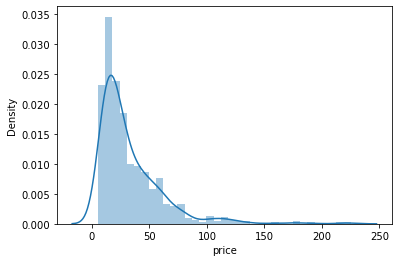

In [8]:
sns.distplot(df_price_sales['price'])

C:\Users\simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

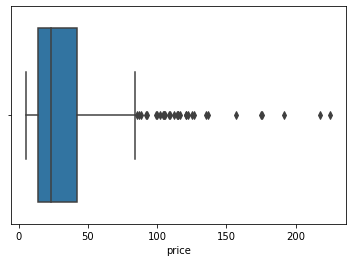

In [9]:
sns.boxplot(df_price_sales['price'])

<AxesSubplot:xlabel='price', ylabel='total_sales'>

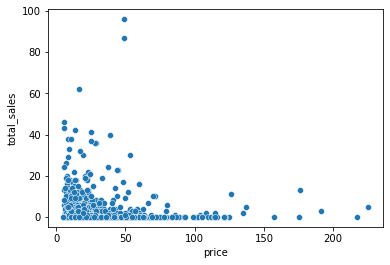

In [10]:
sns.scatterplot(data=df_price_sales, x="price", y="total_sales")

## Méthode du z-score

In [11]:
df_for_zscore = df_price_sales.apply(zscore)
df_for_zscore.head(5)

,total_sales,price
1,-0.470754,0.064556
2,-0.470754,-0.420902
3,-0.118553,-0.661833
4,-0.470754,0.485287
5,-0.470754,0.064556


In [12]:
df_for_zscore = df_for_zscore.sort_values(by=['price'], ascending=False)
df_for_zscore.head(31)

,total_sales,price
290,0.116248,6.922101
517,-0.470754,6.652402
678,-0.118553,5.710254
309,1.055451,5.160068
644,-0.470754,5.124108
312,-0.470754,4.476831
472,0.116248,3.757633
733,-0.235953,3.685714
292,0.820650,3.380055
602,-0.470754,3.318923


C:\Users\simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

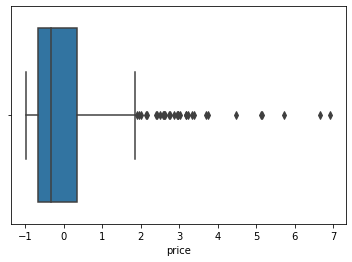

In [13]:
sns.boxplot(df_for_zscore['price'])

In [14]:
df_price_sales['outliers'] = df_for_zscore['price'] > 2
df_price_sales
#Création de ma colonne "outliers" --> True = outliers, False = non outliers

<ipython-input-14-d165498b6d73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_sales['outliers'] = df_for_zscore['price'] > 2


,total_sales,price,outliers
1,0.0,34.3,False
2,0.0,20.8,False
3,3.0,14.1,False
4,0.0,46.0,False
5,0.0,34.3,False
...,...,...,...
800,5.0,8.4,False
801,0.0,27.5,False
802,0.0,69.0,False
803,0.0,54.8,False


<AxesSubplot:xlabel='price', ylabel='total_sales'>

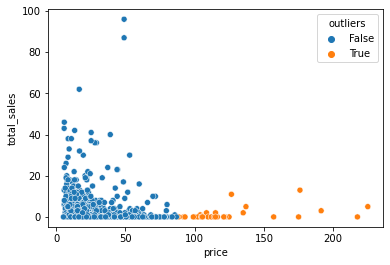

In [15]:
sns.scatterplot(data=df_price_sales, x="price", y="total_sales", hue='outliers')

# - CALCUL DU CHIFFRE D'AFFAIRE

In [16]:
df_price_sales['turnover'] = df_price_sales.price * df_price_sales.total_sales
#CHIFFRE D'AFFAIRE PAR PRODUIT
df_price_sales

<ipython-input-16-e3799b7a7c7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_sales['turnover'] = df_price_sales.price * df_price_sales.total_sales


,total_sales,price,outliers,turnover
1,0.0,34.3,False,0.0
2,0.0,20.8,False,0.0
3,3.0,14.1,False,42.3
4,0.0,46.0,False,0.0
5,0.0,34.3,False,0.0
...,...,...,...,...
800,5.0,8.4,False,42.0
801,0.0,27.5,False,0.0
802,0.0,69.0,False,0.0
803,0.0,54.8,False,0.0


In [17]:
#CHIFFRE D'AFFAIRE TOTAL
df_price_sales['turnover'].sum()

70423.40000000001

<AxesSubplot:xlabel='price', ylabel='turnover'>

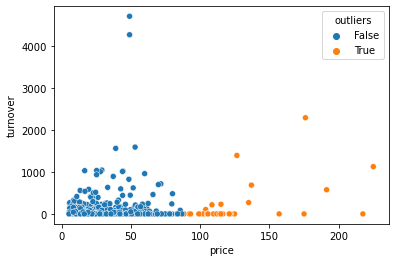

In [18]:
#REPRESENTATION DE LA RENTABILITE DES PRODUITS EN FONCTION DE LEUR PRIX
sns.scatterplot(data=df_price_sales, x="price", y="turnover", hue='outliers')

# Clustering et KMeans

In [19]:
df_price_sales = df_price_sales.sort_values(by='price')

In [20]:
df_price_sales #Jeu de donnée utilisé pour le clustering

,total_sales,price,outliers,turnover
736,0.0,5.2,False,0.0
190,6.0,5.7,False,34.2
188,43.0,5.7,False,245.1
189,13.0,5.7,False,74.1
651,0.0,5.7,False,0.0
...,...,...,...,...
644,0.0,175.0,True,0.0
309,13.0,176.0,True,2288.0
678,3.0,191.3,True,573.9
517,0.0,217.5,True,0.0


In [21]:
X = df_price_sales

X_train, X_test = train_test_split(X, test_size=0.40, random_state=34)
kmeans = KMeans(n_clusters=5, random_state=34).fit(X_train)
X_test['cluster'] = kmeans.predict(X_test) 

<ipython-input-21-77ceab290e35>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cluster'] = kmeans.predict(X_test)


<AxesSubplot:xlabel='price', ylabel='total_sales'>

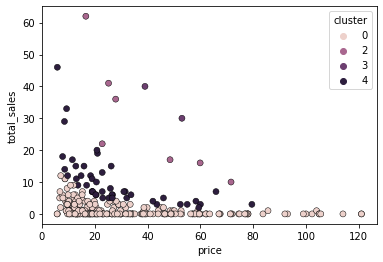

In [22]:
sns.scatterplot(data=X_test, x="price", y="total_sales", hue='cluster', edgecolor='black')

### Analyse des Clusters obtenus

In [23]:
#Extraction de chaque cluster dans des dataframes séparés
X_test_0 = X_test.query('cluster == 0')
X_test_2 = X_test.query('cluster == 2')
X_test_3 = X_test.query('cluster == 3')
X_test_4 = X_test.query('cluster == 4')

In [24]:
#On cherche à comparer la moyenne des prix pour chaque cluster unique, avec la moyenne de prix total
x0_pr = X_test_0['price'].mean()
x2_pr = X_test_2['price'].mean()
x3_pr = X_test_3['price'].mean()
x4_pr = X_test_4['price'].mean()
xtot_pr = X_test['price'].mean()

print('moyenne price :', '\n', x0_pr, '\n', x2_pr, '\n', x3_pr, '\n', x4_pr, '\n', xtot_pr)

moyenne price : 
 33.28008658008659 
 38.92857142857143 
 46.0 
 27.438043478260862 
 32.567657342657334


In [25]:
#Idem pour la moyenne des vente totales
x0_ts = X_test_0['total_sales'].mean()
x2_ts = X_test_2['total_sales'].mean()
x3_ts = X_test_3['total_sales'].mean()
x4_ts = X_test_4['total_sales'].mean()
xtot_ts = X_test['total_sales'].mean()

print('moyenne total sales :', '\n', x0_ts, '\n', x2_ts, '\n', x3_ts, '\n', x4_ts, '\n', xtot_ts)

moyenne total sales : 
 1.225108225108225 
 29.142857142857142 
 35.0 
 10.369565217391305 
 3.6153846153846154


In [26]:
#Idem pour la rentabilité
x0_tnvr = X_test_0['turnover'].mean()
x2_tnvr = X_test_2['turnover'].mean()
x3_tnvr = X_test_3['turnover'].mean()
x4_tnvr = X_test_4['turnover'].mean()
xtot_tnvr = X_test['turnover'].mean()

print('moyenne rentabilité :', '\n', x0_tnvr, '\n', x2_tnvr, '\n', x3_tnvr, '\n', x4_tnvr, '\n', xtot_tnvr)

moyenne rentabilité : 
 19.974025974025974 
 866.7571428571429 
 1575.0 
 198.85652173913047 
 80.3451048951049


In [27]:
#Détail de l'effectif de chaque cluster
x0_size = X_test_0.shape[0]
x2_size = X_test_2.shape[0]
x3_size = X_test_3.shape[0]
x4_size = X_test_4.shape[0]

print('effectif', '\n', x0_size, '\n', x2_size, '\n', x3_size, '\n', x4_size)

effectif 
 231 
 7 
 2 
 46
